## 3D point cloud to 2D individual images

In [10]:
import numpy as np
import cv2
import json
import os
import yaml
import torch
import pdb
import open3d as o3d
import matplotlib.pyplot as plt
%matplotlib inline

calib_folder = './calibration'
global_config = os.path.join(calib_folder, 'defaults.yaml')
camera_config = os.path.join(calib_folder, 'cameras.yaml')
with open(global_config) as f:
    global_config_dict = yaml.safe_load(f)

with open(camera_config) as f:
    camera_config_dict = yaml.safe_load(f)
    
def cart2hom(pts_3d: np.array) -> np.array:
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom

In [11]:

TRAIN =[
    'bytes-cafe-2019-02-07_0',
    'clark-center-2019-02-28_0',
    'clark-center-2019-02-28_1',
    'clark-center-intersection-2019-02-28_0',
    'cubberly-auditorium-2019-04-22_0',
    'forbes-cafe-2019-01-22_0',
    'gates-159-group-meeting-2019-04-03_0',
    'gates-ai-lab-2019-02-08_0',
    'gates-basement-elevators-2019-01-17_1',
    'gates-to-clark-2019-02-28_1',
    'hewlett-packard-intersection-2019-01-24_0',
    'huang-2-2019-01-25_0',
    'huang-basement-2019-01-25_0',
    'huang-lane-2019-02-12_0',
    'jordan-hall-2019-04-22_0',
    'memorial-court-2019-03-16_0',
    'meyer-green-2019-03-16_0',
    'nvidia-aud-2019-04-18_0',
    'packard-poster-session-2019-03-20_0',
    'packard-poster-session-2019-03-20_1',
    'packard-poster-session-2019-03-20_2',
    'stlc-111-2019-04-19_0',
    'svl-meeting-gates-2-2019-04-08_0',
    'svl-meeting-gates-2-2019-04-08_1',
    'tressider-2019-03-16_0',
    'tressider-2019-03-16_1',
    'tressider-2019-04-26_2'
]


In [12]:
sensor = "sensor_0"
lidar = "upper"
data_root = "/home/tho/datasets/JRDB2022/train_dataset_with_activity"
# translation = {
#     "sensor_8": {"upper2indi":{"T": torch.tensor([0,0,-0.17]), "theta": 0.417*np.pi},
#                  "lower2indi":{"T": torch.tensor([0,0,0.27]), "theta": 0.3935*np.pi}},
    
#     "sensor_6": {"upper2indi":{"T": torch.tensor([0,0,-0.10]), "theta": 0.840*np.pi},
#                  "lower2indi":{"T": torch.tensor([0,0,0.3]), "theta": 0.815*np.pi}},
    
#     "sensor_4": {"upper2indi":{"T": torch.tensor([0,0,-0.22]), "theta": 1.235*np.pi},
#                  "lower2indi":{"T": torch.tensor([0,0,0.26]), "theta": 1.21*np.pi}},
    
#     "sensor_2": {"upper2indi":{"T": torch.tensor([0,0,-0.31]), "theta": 1.622*np.pi},
#                  "lower2indi":{"T": torch.tensor([0,0,0.18]), "theta": 1.598*np.pi}},
    
#     "sensor_0": {"upper2indi":{"T": torch.tensor([0,0,-0.25]), "theta": 0.028*np.pi},
#                  "lower2indi":{"T": torch.tensor([0,0,0.18]), "theta": 0.005*np.pi}},
# }
translation = {
    "sensor_8": {"upper2indi":{"T": torch.tensor([0,0,-0.17]), "theta": 0.417*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.24]), "theta": 0.394*np.pi}},
    
    "sensor_6": {"upper2indi":{"T": torch.tensor([0,0,-0.10]), "theta": 0.840*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.32]), "theta": 0.813*np.pi}},
    
    "sensor_4": {"upper2indi":{"T": torch.tensor([0,0,-0.22]), "theta": 1.237*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.24]), "theta": 1.21*np.pi}},
    
    "sensor_2": {"upper2indi":{"T": torch.tensor([0,0,-0.31]), "theta": 1.622*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.18]), "theta": 1.598*np.pi}},
    
    "sensor_0": {"upper2indi":{"T": torch.tensor([0,0,-0.25]), "theta": 0.028*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.22]), "theta": 0.005*np.pi}},
}

In [4]:
from numpy.linalg import inv
# loc = 'bytes-cafe-2019-02-07_0'
# plt.figure()

images = {
    "sensor_8": None,
    "sensor_6": None,
    "sensor_4": None,
    "sensor_2": None,
    "sensor_0": None,
}

config = {'upper': {},
         'lower':{}}
#subplot(r,c) provide the no. of rows and columns
# fig = plt.figure(figsize=(15, 15))
for i, loc in enumerate(TRAIN):
    for idx, (sensor, v) in enumerate(translation.items()):
        all_pts_2d = None
        K = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['K'][:-1].split()]).reshape(3,3)
        R = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['R'][:-1].split()]).reshape(3,3)
        T = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['T'].split()]).reshape(3,1)/1000
        D = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['D'].split()])

        for lidar in [
            'upper',
                      'lower'
                     ]:
            ## Lidar to ego
            L2E_trans = -np.asarray(global_config_dict['calibrated'][f'lidar_{lidar}_to_rgb']['translation']).reshape([3,1])
            L2E_theta = global_config_dict['calibrated'][f'lidar_{lidar}_to_rgb']['rotation'][-1]
            c = np.cos(L2E_theta)
            s = np.sin(L2E_theta)
            L2E_rots = [[c,-s, 0],
                        [s, c, 0],
                        [0, 0, 1]]
            lidar2ego = np.vstack([np.hstack([L2E_rots, L2E_trans]),[0,0,0,1]])
            L2E_RT_inv = inv(lidar2ego)



            lidar2indi = v[f'{lidar}2indi']
            trans = -lidar2indi['T'].reshape([3,1])
            t = lidar2indi['theta']
            rots = np.zeros([4,4])
            c = np.cos(t)
            s = np.sin(t)
            rots = [[c,-s, 0],
                    [s, c, 0],
                    [0, 0, 1]]
            new_RT = np.vstack([np.hstack([rots, trans]),[0,0,0,1]])
            swap = np.array([[0 ,-1, 0, 0],
                             [0 , 0,-1, 0],
                             [1 , 0, 0, 0],
                             [0 , 0, 0, 1]])

            old_RT = np.vstack([np.hstack((R,T)), [0,0,0,1]])
            ego2cam = old_RT.dot(swap)
            lidar2ego =
            # lidar2cam = ego2cam.dot(new_RT)
            # ego2cam = lidar2cam.dot(L2E_RT_inv)

SyntaxError: invalid syntax (1383155166.py, line 59)

## LIDARs to camera, export calibration

sensor_8 lidar: upper
sensor_8 lidar: lower
sensor_6 lidar: upper
sensor_6 lidar: lower
sensor_4 lidar: upper
sensor_4 lidar: lower
sensor_2 lidar: upper
sensor_2 lidar: lower
sensor_0 lidar: upper
sensor_0 lidar: lower


/tmp/ipykernel_510497/2867745967.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 10))


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

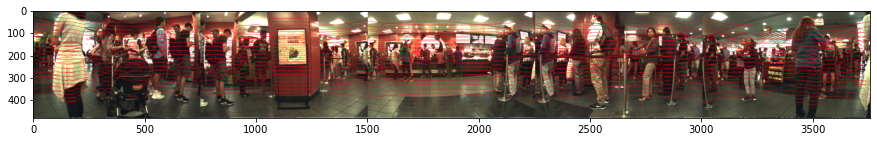

In [14]:
from numpy.linalg import inv
# loc = 'bytes-cafe-2019-02-07_0'
# plt.figure()

images = {
    "sensor_8": None,
    "sensor_6": None,
    "sensor_4": None,
    "sensor_2": None,
    "sensor_0": None,
}

config = {'upper': {},
         'lower':{}}
#subplot(r,c) provide the no. of rows and columns
# fig = plt.figure(figsize=(15, 15))
for i, loc in enumerate(TRAIN):
    for idx, (sensor, v) in enumerate(translation.items()):
        all_pts_2d = None
        K = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['K'][:-1].split()]).reshape(3,3)
        R = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['R'][:-1].split()]).reshape(3,3)
        T = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['T'].split()]).reshape(3,1)/1000
        D = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['D'].split()])

        for lidar in [
            'upper',
                      'lower'
                     ]:
            ## Lidar to ego
            L2E_trans = -np.asarray(global_config_dict['calibrated'][f'lidar_{lidar}_to_rgb']['translation']).reshape([3,1])
            L2E_theta = global_config_dict['calibrated'][f'lidar_{lidar}_to_rgb']['rotation'][-1]
            c = np.cos(L2E_theta)
            s = np.sin(L2E_theta)
            L2E_rots = [[c,-s, 0],
                        [s, c, 0],
                        [0, 0, 1]]
            lidar2ego = np.vstack([np.hstack([L2E_rots, L2E_trans]),[0,0,0,1]])
            L2E_RT_inv = inv(lidar2ego)
            


            lidar2indi = v[f'{lidar}2indi']
            trans = -lidar2indi['T'].reshape([3,1])
            t = lidar2indi['theta']
            rots = np.zeros([4,4])
            c = np.cos(t)
            s = np.sin(t)
            rots = [[c,-s, 0],
                    [s, c, 0],
                    [0, 0, 1]]
            new_RT = np.vstack([np.hstack([rots, trans]),[0,0,0,1]])
            swap = np.array([[0 ,-1, 0, 0],
                             [0 , 0,-1, 0],
                             [1 , 0, 0, 0],
                             [0 , 0, 0, 1]])

            old_RT = np.vstack([np.hstack((R,T)), [0,0,0,1]])
            ego2cam = old_RT.dot(swap)
            lidar2cam = ego2cam.dot(new_RT)
            ego2cam = lidar2cam.dot(L2E_RT_inv)
            if i == 0:
                print(sensor, f"lidar: {lidar}")
                config[sensor] = {}
                config[lidar]['lidar2ego'] = lidar2ego.tolist()
                # config[lidar][sensor] ={}
                # config[lidar][sensor]['ego2cam'] = ego2cam.tolist()
                config[sensor]['ego2cam'] = ego2cam.tolist()
                config[sensor]['D'] = D.tolist()
                config[sensor]['K'] = K.tolist()


            pcd = o3d.io.read_point_cloud(f"{data_root}/pointclouds/{lidar}_velodyne/{loc}/000000.pcd")
            image = cv2.imread(f"{data_root}/images/image_{sensor[-1]}/{loc}/000000.jpg")

            points_3d = np.array(pcd.points)
            hom_points = cart2hom(points_3d)

#             pts_ref = np.dot(lidar2cam, np.transpose(hom_points))
            pts_ref = ego2cam.dot(lidar2ego).dot(np.transpose(hom_points))
            pts_ref = np.transpose(pts_ref)
            pts_ref = pts_ref[pts_ref[:,2]>0]

            # Normalize
            x, y = pts_ref[:,0]/pts_ref[:,2], pts_ref[:,1]/pts_ref[:,2]

            # Calculate radial distortion
            k1,k2,k3,k4,k5 = D
            k6 = 0

            r2 = x**2 + y**2
            r4 = r2**2
            r6 = r2 * r4
            rad_dist = (1 + k1*r2 + k2*r4 + k3*r6) 
            # Get intrinsics params
            fx, _, cx = K[0]
            _, fy, cy = K[1]
            # Apply radial distortion and intrinsic parameters
            xd = fx * x * rad_dist + cx
            yd = fy * y * rad_dist + cy
            # Get the 2D points
            pts_2d = np.stack([xd,yd]).transpose()

            if all_pts_2d is not None:
                all_pts_2d = np.vstack([all_pts_2d, pts_2d])
            else:
                all_pts_2d = pts_2d

        # Visualize
        plt.figure(figsize=(15, 10))
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        for pts in all_pts_2d:
            if (0<pts[0]<1000) and (0<pts[1]<1000):
                cv2.circle(hsv_image, (int(pts[0]), int(pts[1])), 1, (0, 255, 255), 1)
        hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)


        images[sensor] = hsv_image

    final_image = cv2.hconcat([images['sensor_6'], images['sensor_8'],
                               images['sensor_0'], images['sensor_2'],
                               images['sensor_4']])
    os.makedirs(f"sample_projection", exist_ok=True)

    cv2.imwrite(f"sample_projection/{loc}_projected.png", final_image)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

    

In [14]:
import sys
import ruamel.yaml
yaml = ruamel.yaml.YAML()
yaml.version = (1,2)
yaml.default_flow_style = None

with open('calibration/lidars.yaml', 'w') as outfile:
    yaml.dump(config, outfile)
    
import yaml   